# Test distance realization algorithms

The purpose of this notebook is to find a way to embed a noisy distance matrix into euclidean space.

## Setup notebook

### Import libraries

In [1]:
# general utilities
import os
import json
import random
import pandas as pd
import numpy as np
import random
from itertools import combinations

# spatial distance manipulations
import scipy.spatial as sps
from sklearn.metrics.pairwise import euclidean_distances

# plotting
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# semantic embdedding
from gensim.models import KeyedVectors
from utils.utils import *

### Set up paths

In [2]:
# set up paths
proj_dir = os.getcwd()
data_dir = os.path.join(proj_dir, 'data')
util_dir = os.path.join(proj_dir, 'utils')
analysis_dir = os.path.join(proj_dir, 'analysis')

### Read in data and models

In [3]:
# read dictionary mapping
with open(os.path.join(data_dir, 'namesToIds.json')) as json_file:
    namesToIds = json.load(json_file)
namesToIds['unlabeled'] = 0
idsToNames = {v: k for k, v in namesToIds.items()}

# read metadata
df = pd.read_csv('data/metadata.csv')
df['labels'] = df.labels.apply(eval)
df['instances'] = df.instances.apply(eval)

# remove unnecessary labels
df.labels.apply(lambda x:
                [x.remove(ele) for ele in ['unknown', 'unlabeled', 'wall', 'floor', 'ceiling'] if ele in x])

# get useful unique values for the possible names, scenes, and scene types
names = list(namesToIds.keys())
phrases = [name.split() for name in names]
scenes = sorted(df.scene.unique())
scene_types = sorted(df.scene_type.unique())

# import semantic embedding model
ft_300 = KeyedVectors.load(
    'models/fasttext-wiki-news-subwords-300.kv', mmap='r')

### Make helper functions

In [4]:
# generates a random number between [0, 2pi]
def generate_angle():
    return 2 * np.pi * random.random()

# draw a set of circles around a central point
def draw_circle(loc=[0, 0], dis=[0, 1, 1, 1, 1]):
    t = np.linspace(0, np.pi*2, 1000)

    for d in dis:
        plt.plot(d * np.cos(t) + loc[0],
                 d * np.sin(t) + loc[1],
                 linewidth=1,
                 c='orange', alpha=0.5)

# elementwise inverse of square dataframe
def inv(data):
    new_data = 1 / data
    np.fill_diagonal(new_data.values, 0)
    np.nan_to_num(new_data.values, copy=False, neginf=0, posinf=0)
    return new_data

# elementwise residue/distance between two representations
def residue(data1, data2):
    return (data1 - data2)**2

## First-attempt: simple distance minimization

### Set up problem

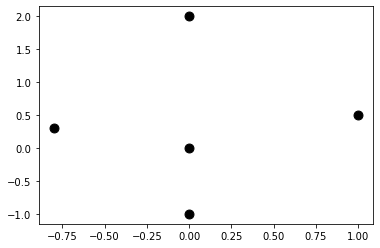

In [5]:
# make a toy problem to reconstruct
points = np.asarray([[0, 0],
                     [0, 2],
                     [1, 0.5],
                     [-0.8, .3],
                     [0, -1]])
dists = euclidean_distances(points)

plt.scatter(points[:, 0], points[:, 1], c='black', s=80)

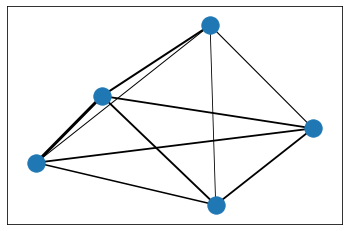

In [6]:
# visualize how well a simple spring layout can capture it
G = nx.from_numpy_matrix(dists)
pos = nx.spring_layout(G)
widths = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos,
                       connectionstyle="arc3,rad=0.3",
                       width=list(widths.values()))

### Try simple solution

In [7]:
# keep lims constant to help plotting
def lims():
    plt.xlim([-3, 3]), plt.ylim([-3, 3])

# select the next point that minimizes our loss function


def select_point(points, dists):
    all_circs = [generate_circs(points[i], dists[i])
                 for i in range(points.shape[0])]
    cands = []
    for circs_1, circs_2 in combinations(all_circs, 2):
        pair_cands = generate_pair_candidates(circs_1, circs_2)
        existing_points = [i for i, x in enumerate(
            pair_cands) for y in points if sum(x - y)**2 < 0.005]
        pair_cands = np.delete(pair_cands, existing_points, 0)

        cands.append(pair_cands)

    if len(cands) > 1:
        choices = generate_choices(cands)
    else:
        choices = cands[0]

    selection = choices[np.random.choice(choices.shape[0])]
    return selection

# generate numpy representations of surrounding circles to run a loss function over
def generate_circs(loc=[0, 0], dis=[1, 1, 1, 1, 1]):
    locs = np.zeros((len(t) * len(dis), 2))
    for i, d in enumerate(dis):
        locs[i*len(t):(i+1)*len(t)] = np.vstack((d *
                                                 np.cos(t) + loc[0], d * np.sin(t) + loc[1])).T
    return np.unique(locs, axis=0)

# generate possible point locations (where two circles overlap)
def generate_pair_candidates(circs_1, circs_2):
    dist_mat = sps.distance_matrix(circs_1, circs_2)
    candidates = circs_1[np.where(dist_mat < .1)[0]]
    return candidates

# recursive function to generate all valid point locations
def generate_choices(cands):
    if len(cands) == 2:
        return generate_pair_candidates(cands[0], cands[1])
    else:
        return generate_choices(cands[1:])

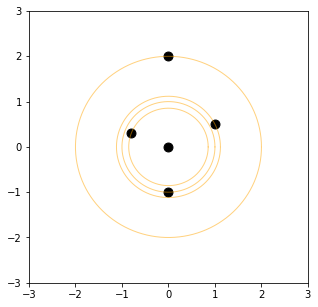

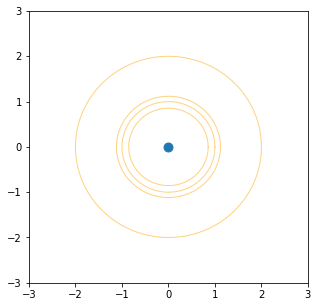

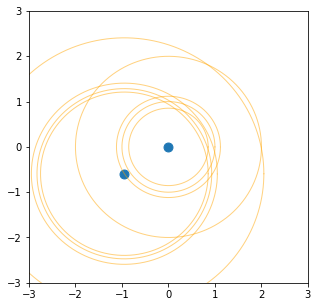

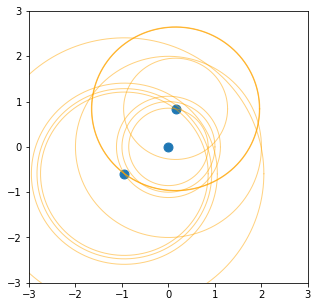

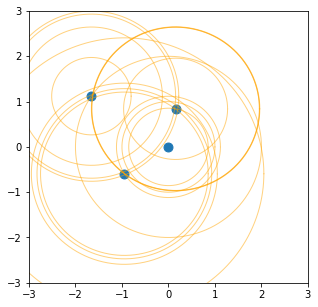

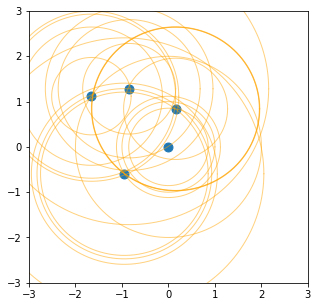

In [8]:
t = np.linspace(0,np.pi*2,1000)

plt.rcParams["figure.figsize"] = (5,5)
points_from_dists = np.zeros((5,2))
points_from_dists[0] = [0,0]

lims()
draw_circle(points_from_dists[0], dists[0])
plt.scatter(points[:, 0], points[:, 1], c='black', s=80)
plt.show()

lims()
draw_circle(points_from_dists[0], dists[0])
plt.scatter(*points_from_dists[0], s=80)
plt.show()


ang = generate_angle()
points_from_dists[1] = [dists[0][2] * np.cos(ang), dists[0][2] * np.sin(ang)]
draw_circle(points_from_dists[0], dists[0])
draw_circle(points_from_dists[1], dists[1])
lims()
plt.scatter(points_from_dists[:2, 0], points_from_dists[:2, 1], s=80)
plt.show()

points_from_dists[2] = select_point(points_from_dists[:2], dists[:2])
draw_circle(points_from_dists[0], dists[0])
draw_circle(points_from_dists[1], dists[1])
draw_circle(points_from_dists[2], dists[2])
lims()
plt.scatter(points_from_dists[:3, 0], points_from_dists[:3, 1], s=80)
plt.show()

points_from_dists[3] = select_point(points_from_dists[:3], dists[:3])
draw_circle(points_from_dists[0], dists[0])
draw_circle(points_from_dists[1], dists[1])
draw_circle(points_from_dists[2], dists[2])
draw_circle(points_from_dists[3], dists[3])
lims()
plt.scatter(points_from_dists[:4, 0], points_from_dists[:4, 1], s=80)
plt.show()

points_from_dists[4] = select_point(points_from_dists[:4], dists[:4])
draw_circle(points_from_dists[0], dists[0])
draw_circle(points_from_dists[1], dists[1])
draw_circle(points_from_dists[2], dists[2])
draw_circle(points_from_dists[3], dists[3])
draw_circle(points_from_dists[4], dists[4])
lims()
plt.scatter(points_from_dists[:5, 0], points_from_dists[:5, 1], s=80)
plt.show()


Conclusions: it's slow and doesn't even work that well! 

## Attempt 2: iteratively select one new point

### Functions to implement new algorithm

In [9]:
# build new location relative to a selected point's location
def new_loc(loc, d, theta):
    return d * np.cos(theta) + loc[0], d * np.sin(theta) + loc[1]

# loss function: sum of square errors between a proposed point's distance between each placed location
# and the distance matrix observation
def loss(prop_loc, locs_2, dists_2):
    return np.square(
        np.sqrt(
            np.square(locs_2 - prop_loc).sum(axis=1)
        ) - dists_2).sum()

# given a distance matrix, produce a set of points obeying that matrix as close as possible
def realize_distances_2d(dist_mat):
    # initialize all points and center the first point ()
    points = np.zeros((dist_mat.shape[0], 2))
    points[0] = [0, 0]

    # create first reference point
    theta = generate_angle()
    points[1] = [dist_mat[0][1] *
                 np.cos(theta), dist_mat[0][1] * np.sin(theta)]

    # place a new point iteratively by minimizing the loss function as the angle from a placed point varies
    # (distance from that placed point is held constant)
    for p_i in range(1, len(points) - 1):
        t, step = np.linspace(0, np.pi*2, 100, retstep=True)
        for i in range(30):
            losses = [(i,
                       loss(
                           new_loc(points[p_i], dist_mat[p_i][p_i + 1], i),
                           points[:p_i],
                           dist_mat[:p_i, p_i + 1]
                       )
                       ) for i in t]
            min_theta_index = np.array(losses)[:, 1].argmin()
#             # bootleg! change this one day
#             if min_theta_index == 0:
#                 min_theta_index += 1
#             elif min_theta_index == 99:
#                 min_theta_index -= 1
            t, step = np.linspace((losses[min_theta_index][0] - step * 3) % (2 * np.pi),
                                  (losses[min_theta_index][0] + step * 3) % (2 * np.pi), 
                                  100, retstep=True)

        theta = losses[min_theta_index][0]
        points[p_i + 1] = new_loc(points[p_i], dist_mat[p_i][p_i + 1], theta)
    return points

### Evaluate toy problem

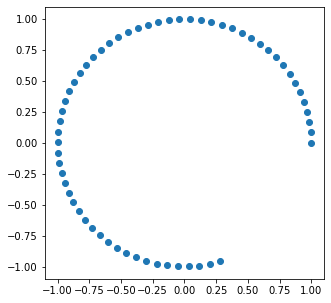

In [10]:
# see if we can reconstruct this piece of a circle
t = np.linspace(0, 5, 60)
points_real = np.vstack((np.cos(t), np.sin(t))).T
dists = euclidean_distances(points_real)
plt.scatter(points_real[:, 0], points_real[:, 1])
plt.show()

In [11]:
# this time, add noise to the distance matrix to make it non-realizable
dists_noise = dists + np.random.random(dists.shape) / 2 - 0.25

In [12]:
# realize distance matrix
points_2d = realize_distances_2d(dists)
points_2d_noise = realize_distances_2d(dists_noise)

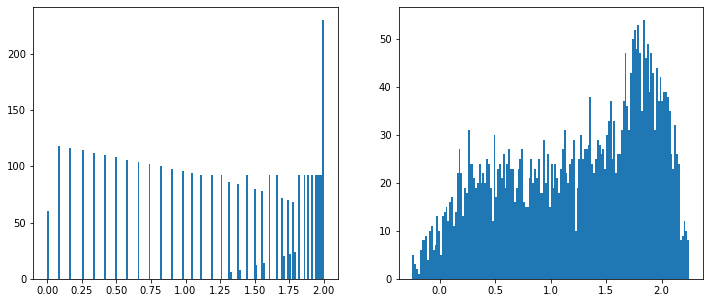

In [13]:
# visualize distance deconstruction effect and realized distances
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(dists.flatten(), bins=150)
axs[1].hist(dists_noise.flatten(), bins=150)
plt.show()

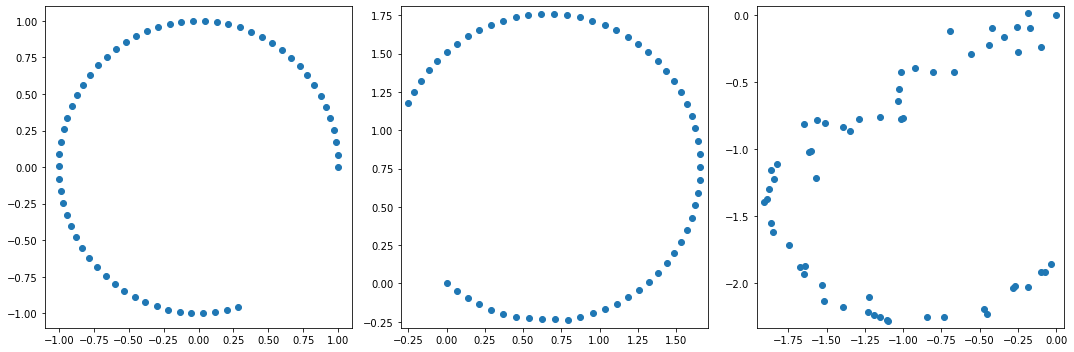

In [14]:
# visualize reconstruction
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(points_real[:, 0], points_real[:, 1])
axs[1].scatter(points_2d[:, 0], points_2d[:, 1])
axs[2].scatter(points_2d_noise[:, 0], points_2d_noise[:, 1])
axs[1].set_xlim(points_2d[:, 0].min() - 0.05, points_2d[:, 0].max() + 0.05)
axs[1].set_ylim(points_2d[:, 1].min() - 0.05, points_2d[:, 1].max() + 0.05)
axs[2].set_xlim(points_2d_noise[:, 0].min() - 0.05, points_2d_noise[:, 0].max() + 0.05)
axs[2].set_ylim(points_2d_noise[:, 1].min() - 0.05, points_2d_noise[:, 1].max() + 0.05)
# axs[0].set_title('Ground Truth')
# axs[1].set_title('Reconstructed points - no noise')
# axs[2].set_title('Reconstructed points - noise applied to EDM')
fig.tight_layout()
plt.show()

Evaluation: it seems to do a lot better! And is significantly faster

### Evaluate plausibility when applied to dissimilarity between objects in a room

In [15]:
# initialize nxn dissimilarity matrix, where each entry is a object label
n = 284
label_sims = pd.DataFrame(index=df.labels[n], columns=df.labels[n])

# compute word2vec similarity for every pair of objects
for word1, word2 in combinations([label.split() for label in df.labels[n]], 2):
    label_sims.at[' '.join(word1), ' '.join(
        word2)] = ft_300.n_similarity(word1, word2)

label_sims = label_sims.fillna(0)
label_sims = label_sims + label_sims.T - np.diag(np.diag(label_sims))

# turn similarity into dissimilarity
label_sims = (1 / label_sims)
np.fill_diagonal(label_sims.values, 0)

In [16]:
# realize dissimilarity matrix
semantic_2d = realize_distances_2d(label_sims.values)
semantic_points = pd.DataFrame(semantic_2d, index = label_sims.index, columns=['x', 'y'])

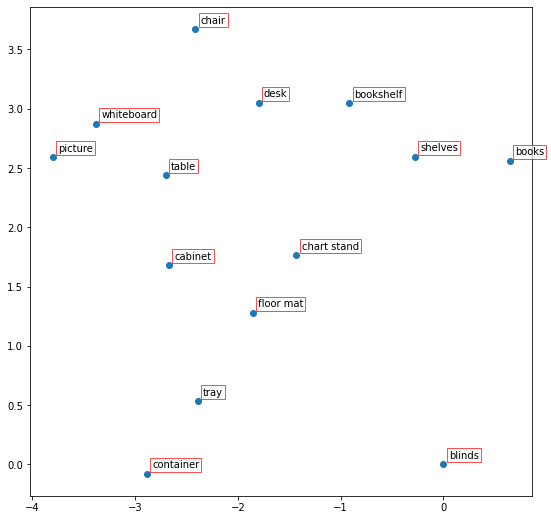

In [17]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(semantic_points.x, semantic_points.y);
for idx, row in semantic_points.iterrows():
    ax.annotate(row.name, (row.x+0.05, row.y+0.05), 
                bbox=dict(facecolor='white', edgecolor='red', alpha=0.7, pad=2))


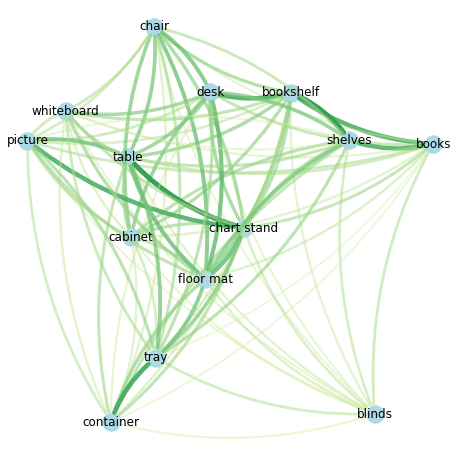

In [18]:
# build graph with our realized dissimilarity matrix
plt.figure(figsize=(8, 8))
G = nx.Graph()

for lab, vals in semantic_points.iterrows():
    G.add_node(lab, pos=tuple(vals))
layout = nx.get_node_attributes(G, 'pos')
edges = [(i, j) for i, j in combinations(G.nodes(), 2)]

label_sims_inv = inv(label_sims)
# while distance is reflected in space, semantic similarity is reflected in the edge size and color
norm = plt.Normalize(
    label_sims_inv.values.flatten().min(),
    label_sims_inv.values.flatten().max()
)

ax = plt.gca()
for edge in edges:
    sim_vals = norm(label_sims_inv.loc[edge[0], edge[1]])
    ax.annotate("",
                xy=layout[edge[0]], xycoords='data',
                xytext=layout[edge[1]], textcoords='data',
                arrowprops=dict(
                    arrowstyle='-',
                    color=plt.cm.YlGn(sim_vals/1.5),
                    lw=sim_vals*5, alpha=sim_vals,
                    shrinkA=10, shrinkB=10,
                    patchA=None, patchB=None,
                    connectionstyle="arc3, rad=0.15"
                ))
nx.draw(G, pos=layout, with_labels=True, node_size=300, node_color='lightblue')

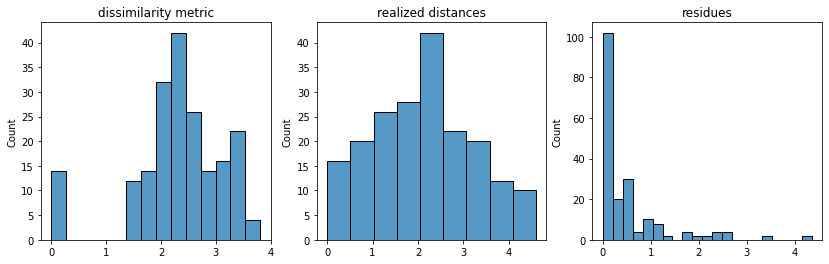

In [19]:
# how far off is our realized matrix from the original similarities?
clean_dists = pd.DataFrame(euclidean_distances(
    semantic_points), index=semantic_points.index, columns=semantic_points.index)
realization_residue = (clean_dists - label_sims)**2

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.histplot(label_sims.values.flatten(), ax=axs[0])
sns.histplot(clean_dists.values.flatten(), ax=axs[1])
sns.histplot(realization_residue.values.flatten(), ax=axs[2])
axs[0].set_title('dissimilarity metric')
axs[1].set_title('realized distances')
axs[2].set_title('residues')
plt.show()

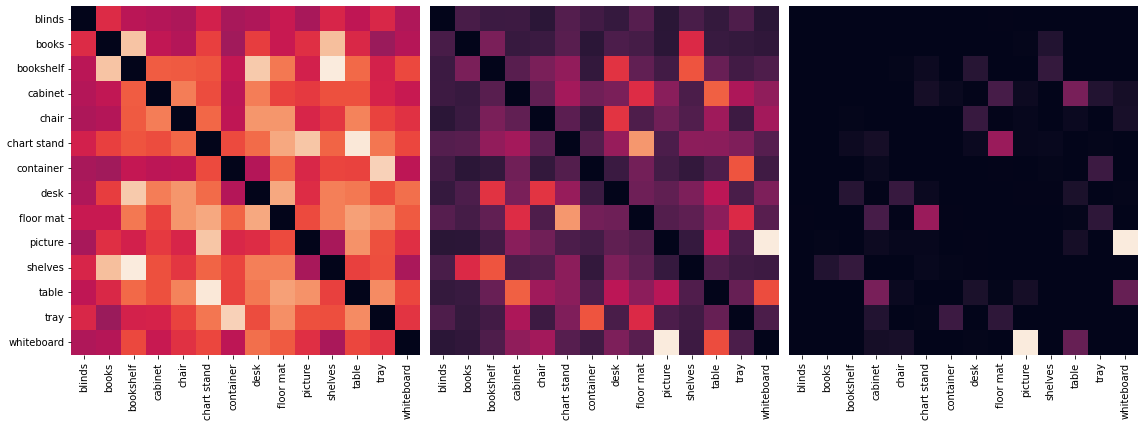

In [20]:
# do the similarities and realized distances look similar?
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
sns.heatmap(inv(label_sims), square=True, ax=axs[0], cbar=False)
sns.heatmap(inv(clean_dists), square=True,
            ax=axs[1], cbar=False, yticklabels=False)
sns.heatmap(residue(inv(label_sims), inv(clean_dists)),
            square=True, cbar=False, ax=axs[2], yticklabels=False)
fig.tight_layout()

## Implement 3D distance realization algorithm
Additionally, we implement a much more intelligent algorithm for placing the optimal point, and vectorize the loss function.

### Create 3D sampling functions

In [21]:
# random rotation matrix
# from http://blog.lostinmyterminal.com/python/2015/05/12/random-rotation-matrix.html
def rand_rotation_matrix(deflection=1.0, randnums=None):
    """
    Creates a random rotation matrix.
    
    deflection: the magnitude of the rotation. For 0, no rotation; for 1, competely random
    rotation. Small deflection => small perturbation.
    randnums: 3 random numbers in the range [0, 1]. If `None`, they will be auto-generated.
    """
    # from http://www.realtimerendering.com/resources/GraphicsGems/gemsiii/rand_rotation.c
    
    if randnums is None:
        randnums = np.random.uniform(size=(3,))
        
    theta, phi, z = randnums
    
    theta = theta * 2.0*deflection*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0*deflection  # For magnitude of pole deflection.
    
    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.
    
    r = np.sqrt(z)
    Vx, Vy, Vz = V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
        )
    
    st = np.sin(theta)
    ct = np.cos(theta)
    
    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))
    
    # Construct the rotation matrix  ( V Transpose(V) - I ) R.
    
    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M

def rand_mat_rot(mat):
    return np.matmul(rand_rotation_matrix(), mat.T).T


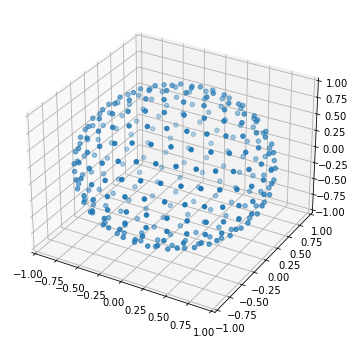

In [22]:
# get evenly distributed points on surface of unit sphere
def fibonacci_sphere(samples=100):

    points = np.zeros((samples, 3))
    samps = np.linspace(0, samples-1, num=samples)
    
    fibb_phis = np.pi * (3. - np.sqrt(5.)) * samps

    points[:, 1] = 1 - (samps / float(samples - 1)) * 2
    rads = np.sqrt(1 - np.square(points[:, 1]))
    points[:, 0] = np.cos(fibb_phis) * rads
    points[:, 2] = np.sin(fibb_phis) * rads

    return points

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
fibonacci_surface = fibonacci_sphere(300)
fib_surf_rots = [rand_mat_rot(fibonacci_surface) for i in range(100)]
rand_fib_surf = random.choice(fib_surf_rots)

ax.scatter(rand_fib_surf[:,0], rand_fib_surf[:,1], rand_fib_surf[:,2])
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.show()

A total of 163 points contained in the unit sphere


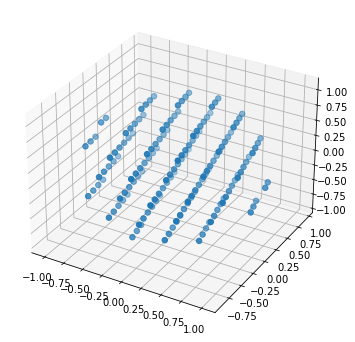

In [23]:
# get tetrahedrally distributed points contained within a unit sphere
num_points = 7
arr, stepa = np.linspace(0, num_points-1, num=num_points, retstep=True)

arr2 = [np.asarray((arr + ((i % 2) == 1) * stepa / 2,
                    np.zeros(num_points) + np.sqrt(3)/2 * i)).T for i in range(num_points)]

arr2 = np.vstack(arr2)

arr_copies = []
for i in range(num_points):
    arr_copy = arr2.copy()
    arr_copy = np.hstack((arr_copy, np.zeros((arr_copy.shape[0], 1))))
    arr_copy[:, 0] += ((i % 2) == 1) / 2
    arr_copy[:, 1] += ((i % 2) == 1) / np.sqrt(12)
    arr_copy[:, 2] += i * np.sqrt(3) / 2
    arr_copies.append(arr_copy)

arr3 = np.vstack(arr_copies)
arr3 = arr3 / (arr3.max(axis=0) / 2) - 1
inds = np.where(np.sqrt(np.square(arr3).sum(axis=1)) <= 1.05)
tetrahedral_ball = arr3[inds]
tet_ball_rots = [rand_mat_rot(tetrahedral_ball) for i in range(100)]
rand_ball = random.choice(tet_ball_rots)

print(f'A total of {tetrahedral_ball.shape[0]} points contained in the unit sphere')
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(rand_ball[:, 0], rand_ball[:, 1], rand_ball[:, 2], s=30)
plt.show()

In [24]:
# build new location relative to a selected point's location
def new_loc(loc, d, theta, phi):
    return d * np.cos(theta) + loc[0], d * np.sin(theta) + loc[1]

# loss function: sum of square errors between a proposed point's distance between each placed location
# and the distance matrix observation
def loss(prop_loss_loc, locs_2, dists_2):
    return np.square(
        np.sqrt(
            np.square(locs_2 - prop_loss_loc).sum(axis=1)
        ) - dists_2).sum()

# vectorized implementation speeds up things by ~10 times
def loss_vec(prop_loss_los, locs_2, dists_2):
    diffs = np.swapaxes(np.moveaxis((locs_2[:, None] - prop_loss_los), 0, -1), 1, 2)
    losses = np.square(np.sqrt(np.square(diffs).sum(axis=2)) - dists_2).sum(axis=1)
    return losses

# given a distance matrix, produce a set of points obeying that matrix as close as possible
def realize_distances_3d(dist_mat):
    # initialize all points and center the first point
    points = np.zeros((dist_mat.shape[0], 3))
    points[0] = [0, 0, 0]

    # create first reference point on the x-axis
    points[1] = [dist_mat[0][1], 0, 0]
    
    # create second reference point, a random location on the circle created by the sphere-sphere intersection
    # https://mathworld.wolfram.com/Sphere-SphereIntersection.html
    # note: unrealizable if d < r + R, so we interpolate between their squared distances 
    d, r, R = dist_mat[0][1], dist_mat[1][2], dist_mat[0][2]
    circ_rad = np.sqrt(max(0, 4 * d ** 2 * R ** 2 - (d ** 2 - r ** 2 + R ** 2) ** 2)) / (2 * d)
    theta = generate_angle()
    x = (d ** 2 - r ** 2 + R ** 2) / (2 * d)
    y = circ_rad * np.cos(theta)
    z = circ_rad * np.sin(theta)
    points[2] = [x, y, z]

    # place a new point iteratively by minimizing the loss function as the angle from a placed point varies
    # (distance from that placed point is held constant)
    for p_i in range(2, len(points) - 1):
        search_rad = dist_mat[p_i][p_i + 1]

        prop_locs = random.choice(fib_surf_rots) * search_rad + points[p_i]
        for i in range(30):

            losses = list(zip(prop_locs, loss_vec(prop_locs, points[:p_i], dist_mat[:p_i, p_i + 1])))
            min_loc_indices = np.argpartition(np.array(losses)[:, 1], 4)[:4]
            min_locs = [losses[min_loc_index][0] for min_loc_index in min_loc_indices]

            search_rad *= 0.7
            prop_locs = np.vstack([random.choice(tet_ball_rots) * search_rad 
                                   + min_loc for min_loc in min_locs])

        min_loc_ind = np.argmin(np.array(losses)[:,1])
        points[p_i + 1] = losses[min_loc_ind][0]
    return points

# ignore deprecation for ragged arrays
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

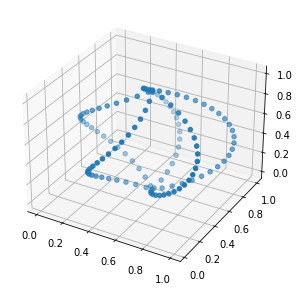

In [25]:
curve = 48
# see if we can reconstruct this piece of a circle
t = np.linspace(0, curve * np.pi, 120)
points_real = np.vstack((10 * np.sin(t/curve) * np.cos(t) + 10, 10 * np.sin(t/curve) * np.sin(t) + 10, t)).T
# squish each dimension between 0 and 10
points_real = points_real / points_real.max(axis=0)
dists = euclidean_distances(points_real)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(points_real[:, 0], points_real[:, 1], points_real[:, 2])
plt.show()

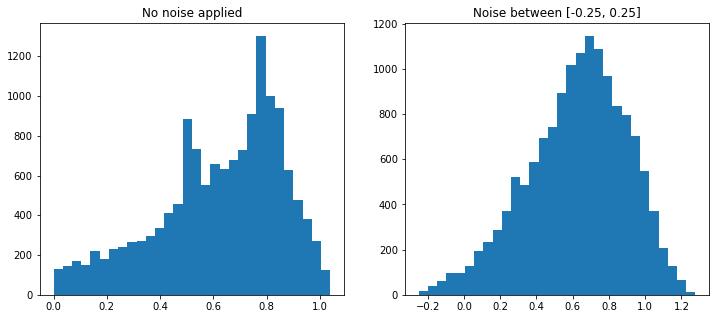

In [26]:
# this time, add noise to the distance matrix to make it non-realizable
dists_noise = dists + np.random.random(dists.shape) / 2 - 0.25

# analyze effect of noise
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].hist(dists.flatten(), bins=30)
axs[1].hist(dists_noise.flatten(), bins=30)
axs[0].set_title('No noise applied')
axs[1].set_title('Noise between [-0.25, 0.25]')
plt.show()

# realize distance matrix
points_3d = realize_distances_3d(dists)
points_3d_noise = realize_distances_3d(dists_noise)

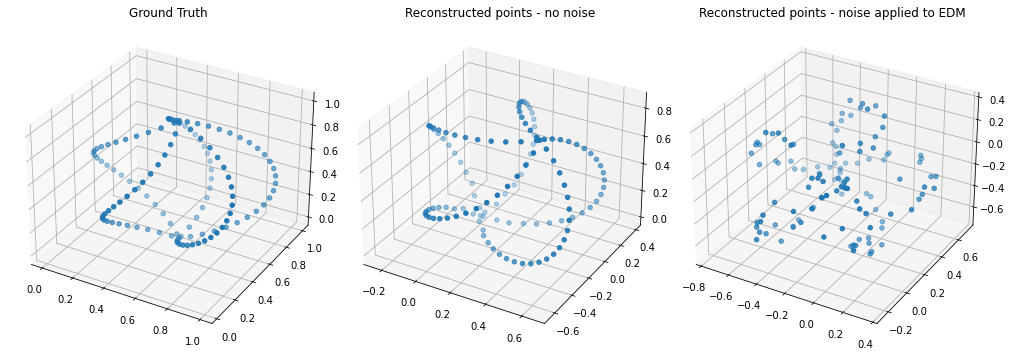

In [27]:
fig = plt.figure(figsize=(14,8))
# set up the axes for the first plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter(points_real[:, 0], points_real[:, 1], points_real[:, 2])
ax.set_title('Ground Truth')

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2])
ax.set_title('Reconstructed points - no noise')

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(points_3d_noise[:, 0], points_3d_noise[:, 1], points_3d_noise[:, 2])
ax.set_title('Reconstructed points - noise applied to EDM')

fig.tight_layout()
plt.show()

In [36]:
points_real = pd.DataFrame(points_real, columns=['x', 'y', 'z'])
points_3d = pd.DataFrame(points_3d, columns=['x', 'y', 'z'])
points_3d_noise = pd.DataFrame(points_3d_noise, columns=['x', 'y', 'z'])

In [38]:
# px.scatter_3d(points_real, 'x', 'y', 'z')
px.scatter_3d(points_3d, 'x', 'y', 'z')
# px.scatter_3d(points_3d_noise, 'x', 'y', 'z')

In [30]:
dists = label_sims.values.copy()
dists = dists / dists.max()

# realize dissimilarity matrix
semantic_3d = realize_distances_3d(dists)
semantic_3d_points = pd.DataFrame(semantic_3d, index = label_sims.index, columns=['x', 'y', 'z'])

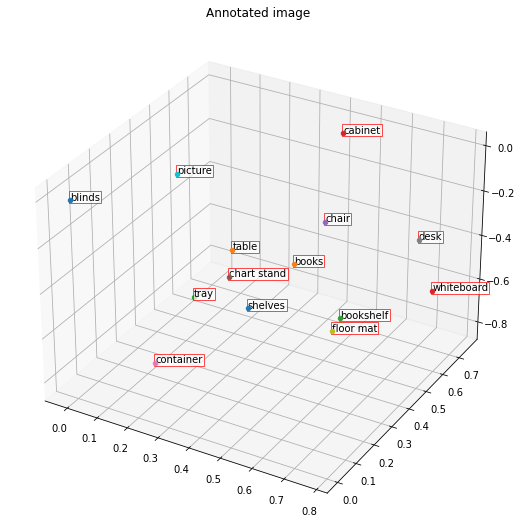

In [31]:
# plot annotated labels on top of image
fig = plt.figure(figsize=(9,12))
ax = fig.add_subplot(projection='3d')

for idx, row in semantic_3d_points.iterrows():
    ax.scatter(row.x, row.y, row.z)
    ax.text(row.x, row.y, row.z, row.name,
                bbox=dict(facecolor='white', edgecolor='red', alpha=0.7, pad=1))
    
ax.set_title('Annotated image')
plt.show()

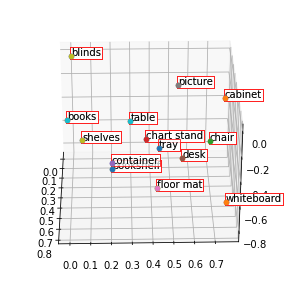

In [32]:
# implement fancy rotation animation
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for idx, row in semantic_3d_points.iterrows():
    ax.scatter(row.x, row.y, row.z)
    ax.text(row.x, row.y, row.z, row.name,
                bbox=dict(facecolor='white', edgecolor='red', alpha=0.7, pad=1))
#ax.grid(False)
#ax.set_axis_off()

def init():
    for idx, row in semantic_3d_points.iterrows():
        ax.scatter(row.x, row.y, row.z)
        ax.text(row.x, row.y, row.z, row.name,
                    bbox=dict(facecolor='white', edgecolor='red', alpha=0.7, pad=1))

    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i/3)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=300, interval=10, blit=True)    
writergif = animation.PillowWriter(fps=30) 
ani.save('semantic_to_spatial.gif', writer=writergif)